In [1]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from core import tsprocess
from core import dataloader
from core import earlystop
from core import helper
import sklearn
from sklearn.metrics import classification_report
matplotlib.style.use('default')

## Overfitting detection

The results of overfitting detection can be found under the [./models](./models) folder:

```shell
models
├── model_date.pickle  # the trained model
├── model_date_train_report.txt  # the results of the train model in the simulated dataset
├── model_date_pred_report.txt  # the results of the train model in the real-world dataset
├── model_date_pred_res.json  # the results of the train model in the real-world dataset in detail
├── ...
└── ...
```


In [2]:
def saveFig(fig, path, dpi=3000):
    fig.savefig(path, dpi=dpi, bbox_inches="tight")

In [3]:
COLOR_PLATE = [
    "#648FFF",
    "#785EF0",
    "#DC267F",
    "#FE6100",
    "#FFB000",
    "grey",
]
FIG_DIR = pathlib.Path("./figs")
FIG_DIR.mkdir(exist_ok=True)

## Examples

### Examples of overfitting and non-overfitting

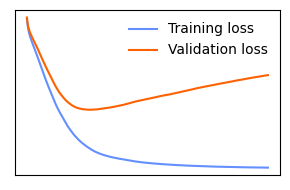

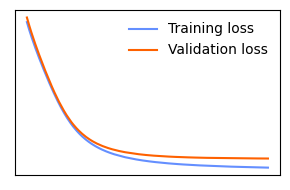

In [4]:
TRAIN_DATA_PATH = pathlib.Path("./data/training/dataset_exp4")
train_set = dataloader.TrainingLogDataset(TRAIN_DATA_PATH)
train_set.loadDataset()

idx = train_set.names.index("training_log_gene_model10_3.json")
data = train_set.data[idx]

fig, ax = plt.subplots()
fig.set_size_inches(3, 2)

ax.plot(data['train_metric'], label="Training loss", color=COLOR_PLATE[0])
ax.plot(data['monitor_metric'], label="Validation loss", color=COLOR_PLATE[3])
# ax.set_ylabel("Loss")
# ax.set_xlabel("Epoch")
ax.legend(loc="upper right", frameon=False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
fig.tight_layout()
saveFig(fig, FIG_DIR / "overfit_example.pdf")
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(3, 2)
idx = train_set.names.index("training_log_cancer_model4_3.json")
data = train_set.data[idx]
ax.plot(data['train_metric'], label="Training loss", color=COLOR_PLATE[0])
ax.plot(data['monitor_metric'], label="Validation loss", color=COLOR_PLATE[3])
# ax.set_ylabel("Loss")
# ax.set_xlabel("Epoch")
ax.legend(loc="upper right", frameon=False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
fig.tight_layout()
saveFig(fig, FIG_DIR / "non_overfit_example.pdf")
plt.show()

### An example of interpolation

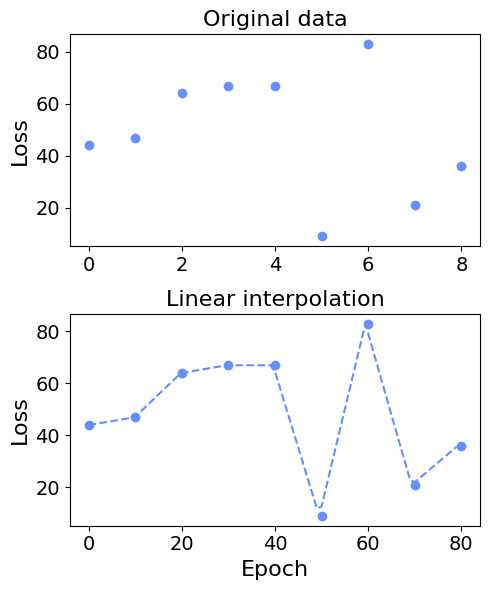

In [5]:
np.random.seed(0)
tmp = np.random.randint(0, 100, size=10)
dst = tsprocess.stretchData(tmp, 100)
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(5, 6)

fontsize = 16
xs = np.arange((len(tmp)))
ax[0].scatter(xs[:9], tmp[:9], label="Training loss", color=COLOR_PLATE[0])
ax[0].set_title("Original data", fontsize=fontsize)
ax[1].scatter((xs * (len(dst) / len(tmp)))[:9], tmp[:9], label="Training loss", color=COLOR_PLATE[0])
ax[1].set_title("Linear interpolation", fontsize=fontsize)
ax[1].plot(dst[:80], ls="--", label="Training loss", color=COLOR_PLATE[0])

ax[0].set_xticks([0, 2, 4, 6, 8])
ax[1].set_xticks([0, 20, 40, 60, 80])
ax[1].set_xlabel("Epoch", fontsize=fontsize)
ax[0].set_ylabel("Loss", fontsize=fontsize)
ax[1].set_ylabel("Loss", fontsize=fontsize)
ax[0].xaxis.set_tick_params(labelsize=fontsize - 2)
ax[0].yaxis.set_tick_params(labelsize=fontsize - 2)
ax[1].xaxis.set_tick_params(labelsize=fontsize - 2)
ax[1].yaxis.set_tick_params(labelsize=fontsize - 2)

fig.tight_layout()
saveFig(fig, FIG_DIR / "interpolate.pdf")
plt.show()

In [6]:
TEST_DATA_PATH = pathlib.Path("./data/testing/real_world_data")
test_set = dataloader.TrainingLogDataset(TEST_DATA_PATH)
test_set.loadDataset()

OUT_PATH = pathlib.Path("./out/test_cmp_early_stop_step10")
OUT_PATH.mkdir(parents=True, exist_ok=True)
print(test_set)

WHOLE_HIS_OUT_PATH = pathlib.Path("./out/test_whole_history_trans")

Loaded dataset from c:\Users\h84248579\Documents\GitHub\overfit_detect\data\testing\real_world_data:
    40 data, 40 labels 
    29 overfitting samples
    11 non_overfitting samples



## Overfitting prevention

### Optimal early stopping results

In [16]:
opt_es_res = {
    "label": test_set.labels,
    "name": test_set.names,
    "is_early_stop": [],
    "early_stop_epoch": [],
    "early_best_epoch": [],
    "early_best_loss": [],
    "max_len": [],
}
is_optimal_es = []
optimal_es_epoch = []
optimal_es_loss = []
for data, label in zip(test_set.data, test_set.labels):
    min_value_epoch = np.argmin(data["monitor_metric"])
    opt_es_res["is_early_stop"].append(min_value_epoch != (len(data["monitor_metric"]) - 1))
    opt_es_res["early_stop_epoch"].append(len(data["monitor_metric"]) - 1)
    opt_es_res["early_best_epoch"].append(min_value_epoch)
    opt_es_res["early_best_loss"].append(data["monitor_metric"][min_value_epoch])
    opt_es_res["max_len"].append(len(data["monitor_metric"]))
opt_es_res = pd.DataFrame.from_dict(opt_es_res)
opt_es_res["early_stop_epoch"] = opt_es_res["early_stop_epoch"].astype(int)
opt_es_res["early_best_epoch"] = opt_es_res["early_best_epoch"].astype(int)
opt_es_res["is_early_stop"] = opt_es_res["is_early_stop"].astype(int)
opt_es_res.to_csv(OUT_PATH / "opt_es.csv", index=False)
opt_es_res.to_csv(WHOLE_HIS_OUT_PATH / "opt_es.csv", index=False)

### Early stopping with different patience parameters

In [8]:
patiences = np.arange(5, 120, 5)
for patience in patiences:
    early_stop_res = {
        "label": test_set.labels,
        "name": test_set.names,
        "is_early_stop": [],
        "early_stop_epoch": [],
        "early_best_epoch": [],
        "early_best_loss": [],
        "max_len": [],
    }
    for data, label in zip(test_set.data, test_set.labels):
        is_early_stop, stop_epoch, best_epoch, best_loss = earlystop.detectEarlyStop(list(range(len(data["monitor_metric"]))), data["monitor_metric"], patience)
        early_stop_res["is_early_stop"].append(is_early_stop)
        early_stop_res["early_stop_epoch"].append(stop_epoch)
        early_stop_res["early_best_epoch"].append(best_epoch)
        early_stop_res["early_best_loss"].append(best_loss)
        early_stop_res["max_len"].append(len(data["monitor_metric"]))
    early_stop_res = pd.DataFrame.from_dict(early_stop_res)
    early_stop_res["early_stop_epoch"] = early_stop_res["early_stop_epoch"].astype(int)
    early_stop_res["early_best_epoch"] = early_stop_res["early_best_epoch"].astype(int)
    early_stop_res["is_early_stop"] = early_stop_res["is_early_stop"].astype(int)
    early_stop_res.to_csv(OUT_PATH / f"patience_{patience}.csv", index=False)

### Our method for overfitting prevention

#### Using rolling window

In [9]:
# for rolling window
res = {
    "window": [],
    "cls": [],
    "acc": [],
    "median_delay": [],
}
WINDOW_SIZES = [20, 40, 60, 80, 100]
for window_size in WINDOW_SIZES:
    for step in [10, ]:
        for idx, cls_name in enumerate(["knndtw", "hmmgmm", "tsf", "tsbf", "bossvs", "saxvsm"]):
            dp = list(OUT_PATH.glob(f"{cls_name}_*_{window_size}_{step}.csv"))[0]
            print("="*9, dp.name, "="*9)
            data = pd.read_csv(dp)
            data = data.sort_values("name").reset_index()
            opt_es_res = pd.read_csv(OUT_PATH / "opt_es.csv")
            opt_es_res = opt_es_res.sort_values("name").reset_index()

            correct = opt_es_res["early_best_epoch"] == data["best_epoch"]
            helper.printPercentage(sum(correct), len(correct), "same as optimal stopping point")
            opt_inspect = opt_es_res[~correct]
            es_inspect = data[~correct]
            diff_epoch = opt_inspect["early_best_epoch"] - es_inspect["best_epoch"]

            mask = data["stop_epoch"] == (opt_es_res["max_len"] - 1)
            diff = data["stop_epoch"] - data["best_epoch"]
            print("[all stop] median of epoch diff:", diff.median(), "max:", diff.max(), "min:", diff.min())

            res["window"].append(window_size)
            res["cls"].append(cls_name)
            res["acc"].append(sum(correct) / len(correct))
            res["median_delay"].append(diff.median())
pd.DataFrame.from_dict(res)

========= knndtw_2022_09_21_01_15_37_20_10.csv =========
31 / 40 = 77.5% same as optimal stopping point
[all stop] median of epoch diff: 31.0 max: 199 min: 0
========= hmmgmm_2022_09_20_21_42_14_20_10.csv =========
8 / 40 = 20.0% same as optimal stopping point
[all stop] median of epoch diff: 5.0 max: 19 min: 0
========= tsf_2022_09_20_21_43_16_20_10.csv =========
21 / 40 = 52.5% same as optimal stopping point
[all stop] median of epoch diff: 12.5 max: 75 min: 2
========= tsbf_2022_09_20_21_43_07_20_10.csv =========
9 / 40 = 22.5% same as optimal stopping point
[all stop] median of epoch diff: 8.5 max: 23 min: 0
========= bossvs_2022_09_20_21_48_44_20_10.csv =========
27 / 40 = 67.5% same as optimal stopping point
[all stop] median of epoch diff: 7.0 max: 199 min: 0
========= saxvsm_2022_09_20_21_44_14_20_10.csv =========
8 / 40 = 20.0% same as optimal stopping point
[all stop] median of epoch diff: 4.0 max: 19 min: 0
========= knndtw_2022_09_21_01_15_37_40_10.csv =========
33 / 40 = 8

,window,cls,acc,median_delay
0,20,knndtw,0.775,31.0
1,20,hmmgmm,0.200,5.0
2,20,tsf,0.525,12.5
3,20,tsbf,0.225,8.5
4,20,bossvs,0.675,7.0
5,20,saxvsm,0.200,4.0
6,40,knndtw,0.825,27.0
7,40,hmmgmm,0.200,6.5
8,40,tsf,0.550,22.0
9,40,tsbf,0.375,15.0


##### Loading data

In [10]:
TS_NAMES = ["knndtw", "hmmgmm", "tsf", "tsbf", "saxvsm", "bossvs"]
TS_SHOWS = {
    "knndtw": "KNN-DTW",
    "hmmgmm": "HMM-GMM",
    "tsf": "TSF",
    "tsbf": "TSBF",
    "saxvsm": "SAX-VSM",
    "bossvs": "BOSSVS",
}

step = 10
cls_res = {
    "ts": [],
    "correct_rate": [],
    "window_size": [],
}
for cls_name in TS_NAMES:
    # for window_size in [10, 25, 75, 50, 100]:
    for window_size in WINDOW_SIZES:
        dp = list(OUT_PATH.glob(f"{cls_name}_*_{window_size}_{step}.csv"))[0]
        # print(dp)
        tsc_res = pd.read_csv(dp)
        
        opt_res = pd.read_csv(OUT_PATH / "opt_es.csv")
        opt_res = opt_res.sort_values("name").reset_index().copy()
        tsc_res = tsc_res.sort_values("name").reset_index().copy()
        tsc_correct = (opt_res["early_best_epoch"] == tsc_res["best_epoch"])
        correct_rate = sum(tsc_correct) / len(tsc_correct)
        
        cls_res["ts"].append(TS_SHOWS[cls_name])
        cls_res["correct_rate"].append(correct_rate)
        cls_res["window_size"].append(window_size)
cls_res = pd.DataFrame.from_dict(cls_res)
cls_res = cls_res.sort_values("window_size")
cls_res.groupby("ts").get_group("KNN-DTW")

,ts,correct_rate,window_size
0,KNN-DTW,0.775,20
1,KNN-DTW,0.825,40
2,KNN-DTW,0.925,60
3,KNN-DTW,0.975,80
4,KNN-DTW,0.975,100


In [11]:
es_patience_res = {
    "patience": [],
    "correct_rate": [],
    "diff_btw_opt": [],
    "diff_btw_best_and_stop": [],
}
for patience in patiences:
    opt_es_res = pd.read_csv(OUT_PATH / "opt_es.csv")
    file_name = f"patience_{patience}.csv"
    data = pd.read_csv(OUT_PATH / file_name)

    correct = opt_es_res["early_best_epoch"] == data["early_best_epoch"]
    opt_inspect = opt_es_res[~correct]
    es_inspect = data[~correct]
    diff_epoch = opt_inspect["early_best_epoch"] - es_inspect["early_best_epoch"]
    
    mask = data["early_stop_epoch"] == (data["max_len"] - 1)
    diff = data.loc[~mask, "early_stop_epoch"] - data.loc[~mask, "early_best_epoch"]
    print(diff.max())
    es_patience_res["patience"].append(patience)
    es_patience_res["correct_rate"].append(sum(correct) / len(correct))
    es_patience_res["diff_btw_opt"].append(diff_epoch.median())
    es_patience_res["diff_btw_best_and_stop"].append(diff.median())
es_patience_res = pd.DataFrame.from_dict(es_patience_res)
es_patience_res

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115


,patience,correct_rate,diff_btw_opt,diff_btw_best_and_stop
0,5,0.175,82.0,5.0
1,10,0.225,84.0,10.0
2,15,0.300,75.0,15.0
3,20,0.475,76.0,20.0
4,25,0.575,76.0,25.0
5,30,0.725,76.0,30.0
6,35,0.725,76.0,35.0
7,40,0.825,132.0,40.0
8,45,0.825,132.0,45.0
9,50,0.850,76.0,50.0


##### Comparing the results between early stopping and the rolling window

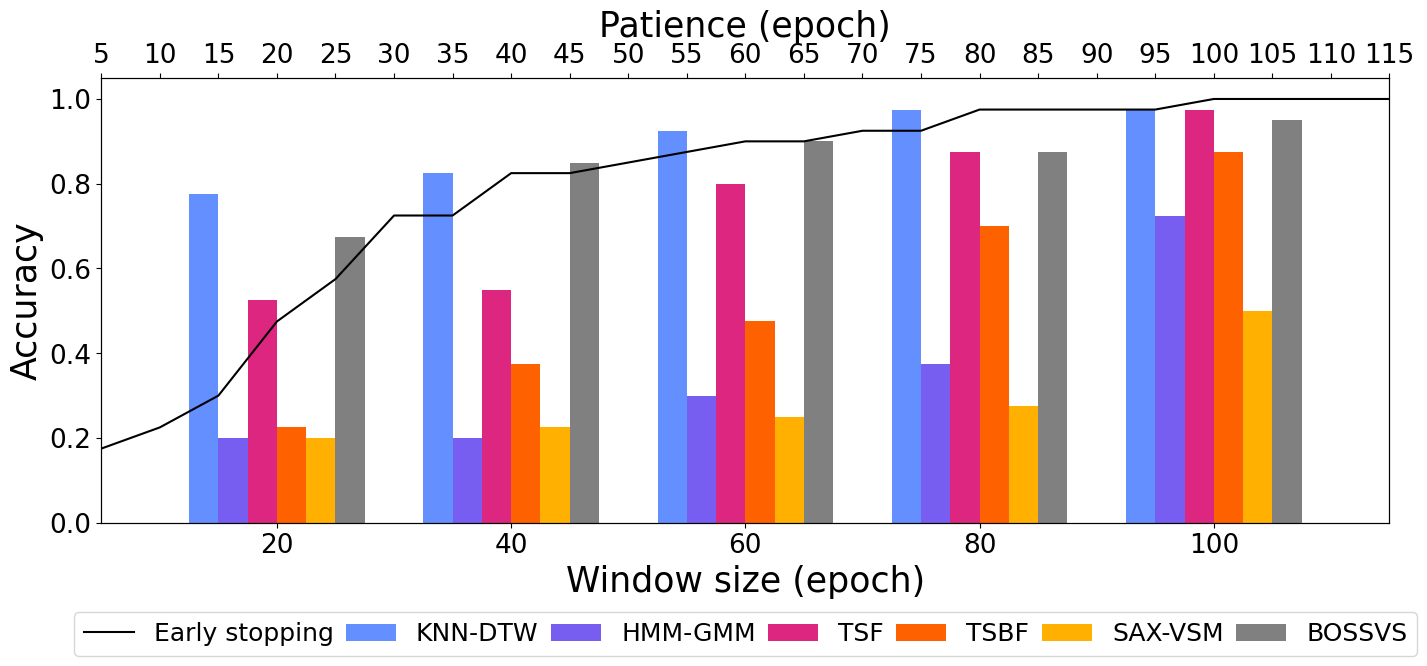

In [14]:
barWidth = 1.0 / 8
fig, axs = plt.subplots()
fig.set_size_inches(15, 7)

ax = axs
window_sizes = [str(w) for w in WINDOW_SIZES]
scale = 20
offset = 20-6.25
brs = [np.arange(len(window_sizes))* scale + offset]
barWidth = barWidth * scale
for i in range(len(TS_SHOWS) - 1):
    brs.append((brs[i] + barWidth))
for i, (br, ts) in enumerate(zip(brs, TS_SHOWS.values())):
    vs = cls_res.groupby("ts").get_group(ts)["correct_rate"]
    ax.bar(
        br, vs, color=COLOR_PLATE[i], width=barWidth, label=ts
    )


fontsize = 23 + 2
titlesize = 27 + 2
ticksize = 17 + 2

ax.set_xlabel('Window size (epoch)', fontsize=fontsize)
ax.set_ylabel('Accuracy', fontsize=fontsize)
ax.set_xticks(WINDOW_SIZES)
ax.set_xticklabels(window_sizes)
ax.xaxis.set_tick_params(labelsize=ticksize)
ax.yaxis.set_tick_params(labelsize=ticksize)
ax.set_ylim(0.0, 1.05)
ax.set_xlim(5, 115)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.plot(es_patience_res["patience"], es_patience_res["correct_rate"], color='k')
ax2.set_xlabel("Patience (epoch)", fontsize=fontsize)
ax2.set_xticks(list(range(5, 120, 5)))
ax2.xaxis.set_tick_params(labelsize=ticksize)
ax.plot(np.nan, np.nan, label="Early stopping", color='k')
ax.legend(loc='center', fontsize=ticksize-1, bbox_to_anchor=(0.5, -0.25), ncol=7, columnspacing=0.5, frameon=True)

fig.tight_layout()
saveFig(fig, FIG_DIR / "cmp_correct_rate_small.pdf")
plt.show()

#### Using the whole history

========= knndtw_2022_09_01_10_57_59_20_20.csv =========
40 40 40
38 / 40 = 95.0% same as optimal stopping point
median of difference: 138.5
median of epoch diff: 43.5 max: 199 min: 3
========= tsf_2022_09_20_21_43_16_20_20.csv =========
40 40 40
36 / 40 = 90.0% same as optimal stopping point
median of difference: 111.0
median of epoch diff: 35.0 max: 103 min: 0
========= tsbf_2022_09_20_21_43_07_20_20.csv =========
40 40 40
33 / 40 = 82.5% same as optimal stopping point
median of difference: 121.0
median of epoch diff: 31.0 max: 129 min: 2
========= bossvs_2022_09_20_21_48_44_20_20.csv =========
40 40 40
26 / 40 = 65.0% same as optimal stopping point
median of difference: 74.5
median of epoch diff: 21.0 max: 191 min: 0
========= hmmgmm_2022_09_25_01_11_13_20_20.csv =========
40 40 40
7 / 40 = 17.5% same as optimal stopping point
median of difference: 86.0
median of epoch diff: 0.0 max: 55 min: 0
========= saxvsm_2022_09_20_21_44_14_20_20.csv =========
40 40 40
13 / 40 = 32.5% same as 

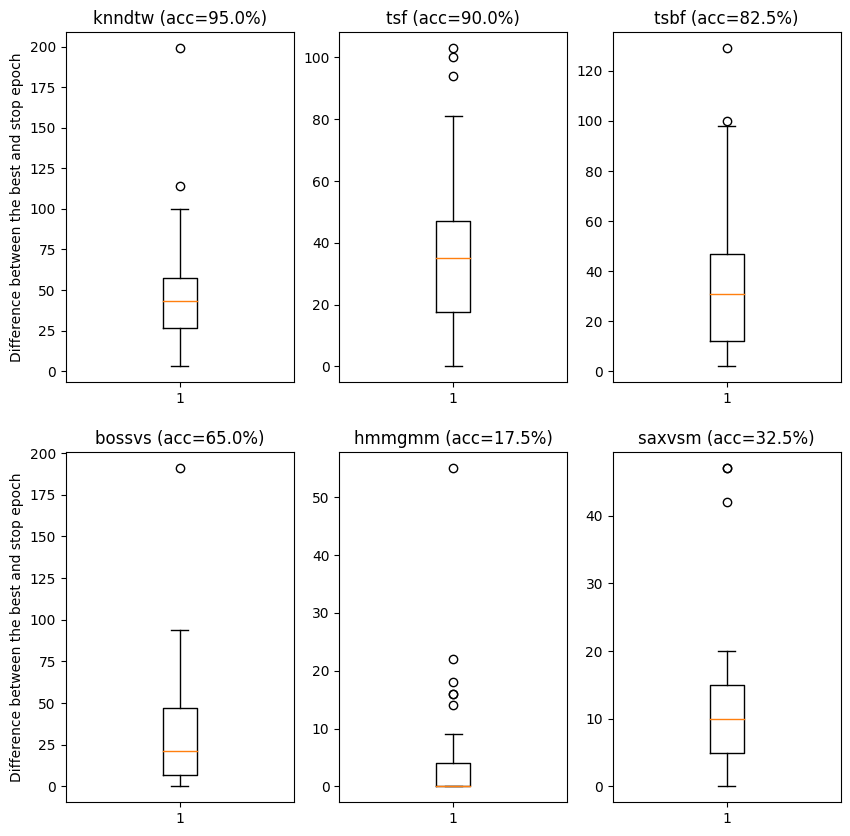

In [22]:
WINDOW_SIZES = [20,]
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(10, 10)
for window_size in WINDOW_SIZES:
    for step in [20, ]:
        for idx, cls_name in enumerate(["knndtw", "tsf", "tsbf", "bossvs", "hmmgmm", "saxvsm"]):
            dp = list(WHOLE_HIS_OUT_PATH.glob(f"{cls_name}_*_{window_size}_{step}.csv"))[0]
            print("="*9, dp.name, "="*9)
            data = pd.read_csv(dp)
            data = data.sort_values("name").reset_index()
            opt_es_res = pd.read_csv(WHOLE_HIS_OUT_PATH / "opt_es.csv")
            opt_es_res = opt_es_res.sort_values("name").reset_index()
            print(len(opt_es_res), len(data), sum(opt_es_res["name"] == data["name"]))

            correct = opt_es_res["early_best_epoch"] == data["best_epoch"]
            helper.printPercentage(sum(correct), len(correct), "same as optimal stopping point")
            acc = sum(correct) / len(correct)
            opt_inspect = opt_es_res[~correct]
            es_inspect = data[~correct]
            diff_epoch = opt_inspect["early_best_epoch"] - es_inspect["best_epoch"]
            print("median of difference:", diff_epoch.median())

            diff = data["stop_epoch"] - data["best_epoch"]
            ax = axs.item(idx)
            ax.set_title(f"{cls_name} (acc={acc*100}%)")
            ax.boxplot(diff)
            print(f"median of epoch diff:", diff.median(), "max:", diff.max(), "min:", diff.min())
axs.item(0).set_ylabel("Difference between the best and stop epoch")
axs.item(3).set_ylabel("Difference between the best and stop epoch")
plt.savefig(FIG_DIR / "whole_history.pdf")
plt.show()